# Maximun a Posteriori Training for Kernel Adaptive Filters

## Model
### Likelihood
$$p(X|\theta) = \prod_{t=1}^N \frac{1}{\sqrt{2\pi\sigma_e^2}} \exp\left( -\frac{\left(y_t - \sum_{i=1}^{\left|D_t\right|}\alpha_i k (x_t, s_i)\right)^2}{2\sigma_e^2} \right)$$

in other words,

$$p(x_t|\theta) \sim \mathcal{N} \left(\sum_{i=1}^{\left|D_t\right|} \alpha_i \exp\left(-\frac{\left\|x_t - s_i\right\|^2}{2\sigma_k^2}\right), \sigma_e^2 \right)$$

### Dictionary Prior
$$p(D) = \frac{1}{\sqrt{2\pi l^2}} \exp \left( -\frac{\left\|k(D_t, D_t)\right\|^2}{2l^2} \right)$$

### Hyperparamter Priors
- $\alpha_i \sim \mathcal{N}(0,\sigma_\alpha)$
- $l \sim \mathcal{N}(0, 1.0)$ or $U_{[\mathbb{R}^+]}$
- $\sigma_k \sim \mathcal{N}(0, 1.0)$ or $U_{[\mathbb{R}^+]}$
- $\sigma_e \sim \mathcal{N}(0, 1.0)$ or $U_{[\mathbb{R}^+]}$
- $\log\left(p(D_t)\right) = \frac{1}{2}\log(2\pi l^2) - \frac{1}{2l^2}\left\|k_{\sigma_k}(D, D) \right\|$

## PyMC 3 Implementation
### Load Data (Lorentz Chaotic Series)

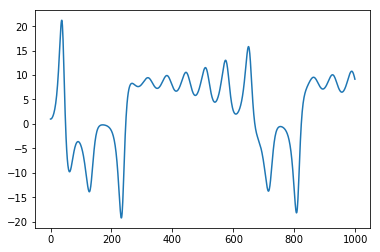

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
data = np.load('./data.npy')[0]  #  Only load 'x' dimension

plt.plot(data)

### Model Definitions

In [2]:
import theano
import theano.tensor as tt

def logp_mean(x, sv, alpha, sigma_k):
    """ Mean of Likelihood Model """
    
    return kern_mat(x, sv, sigma_k).dot(alpha)

def kern_mat(x, sv, sigma_k):
    """ kernel(x ,s) where |x| != |s| """
    outer = x[:, None] - sv[None, :]
    return np.exp(-1/(2*sigma_k**2)*outer**2)

def logp_d(sv, sigma_l, sigma_k):
    """ Log-Prior of Dictionary """
    return -0.5*tt.log(2*np.pi*sigma_l**2) - 1/(2*sigma_l**2)*(norm_gram(sv, sigma_k)**2)

def norm_gram(sv, sigma_k):
    """ Norm of Gram Matrix of Dictionary """
    outer = sv[:, None] - sv[None, :]
    return tt.sum(tt.exp(-1/(2*sigma_k**2)*outer**2)) 

In [5]:
import unittest

class KernelTest(unittest.TestCase):
    def setUp(self):
        dict_size     = 10
        self.x0       = np.arange(20)
        self.s0       = np.ones(dict_size)
        self.alpha0   = 2 * np.ones(dict_size)
        self.sigma_k0 = 10.0
        self.sigma_l0 = 2.0
        
        #self.xt       = theano.shared(np.asarray(self.x0, dtype=theano.config.floatX))
        self.xt       = theano.shared(self.x0)
        #self.xt       = self.xt.dimshuffle(0, 'x')
        #self.xt       = self.xt.reshape((self.x0.shape[0], 1))
        self.st       = self.s0  # Uniform('s', np.min(self.x0), np.max(self.x0), shape=(dict_size,))
        self.alphat   = self.alpha0  # Normal('a', sd=10, shape=(dict_size,))
        self.sigma_kt = self.sigma_k0  # 10.0
        self.sigma_lt = self.sigma_l0  # 2.0
    
    # numpy arguments
    
    def test_logp_mean0(self):
        mu = logp_mean(self.x0, self.s0, self.alpha0, self.sigma_k0)
        
        xs = self.x0.shape
        
        self.assertEqual(mu.shape, (xs[0],))
    
    def test_kern_mat0(self):
        k = kern_mat(self.x0, self.s0, self.sigma_k0)
        
        xs = self.x0.shape
        ss = self.s0.shape
        
        self.assertEqual(k.shape, (xs[0], ss[0]))
    
    def test_logp_d0(self):
        lpd = logp_d(self.s0, self.sigma_l0, self.sigma_k0)
        self.assertEqual(lpd.shape.eval().shape[0], 0)
    
    def test_norm_gram0(self):
        norm = norm_gram(self.s0, self.sigma_k0)
        self.assertEqual(norm.shape.eval().shape[0], 0)
    
    # theano arguments
    
    def test_logp_mean_theano(self):
        mu = logp_mean(self.xt, self.st, self.alphat, self.sigma_kt)
        
        xs = self.xt.shape.eval()
        
        self.assertEqual(mu.shape.eval(), (xs[0],))
    
    def test_kern_mat_theano(self):
        k = kern_mat(self.xt, self.st, self.sigma_kt)
        
        xs = self.xt.shape.eval()
        ss = self.st.shape
        
        self.assertEqual(tuple(k.shape.eval()), (xs[0], ss[0]))
    
    def test_logp_d_theano(self):
        lpd = logp_d(self.st, self.sigma_lt, self.sigma_kt)
        self.assertEqual(lpd.shape.eval().shape[0], 0)
    
    def test_norm_gram_theano(self):
        norm = norm_gram(self.st, self.sigma_kt)
        self.assertEqual(norm.shape.eval().shape[0], 0)

suite = unittest.TestLoader().loadTestsFromTestCase(KernelTest)
unittest.TextTestRunner().run(suite)

........
----------------------------------------------------------------------
Ran 8 tests in 0.750s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

### PyMC3 Sampling

In [122]:
from pymc3 import (Model, Normal, HalfNormal, Uniform, Flat, Potential, 
                   Slice, Metropolis, sample, traceplot, find_MAP)

adaptive_model = Model()

dict_size = 2
x = data[0:1000-1]
y = data[1:1000]

with adaptive_model:
    sigma_e = HalfNormal('sigma_e', sd=10.)
    sigma_k = HalfNormal('sigma_k', sd=10.)
    sigma_l = HalfNormal('sigma_l', sd=10.)
    
    s = Uniform('s', np.min(x), np.max(x), shape=dict_size)
    a = Normal('a', sd=1, shape=dict_size)
    
    tx = theano.shared(np.asarray(x, dtype=theano.config.floatX))
    
    logp_dict = Potential('logp_dict', logp_d(s, sigma_l, sigma_k))
    mu = logp_mean(tx, s, a, sigma_k)
    
    print(mu.shape, y.shape, sigma_e.shape)
    logp_like = Normal('like', mu=mu, sd=sigma_e, observed=y)
    
    step = Metropolis()
    #start = find_MAP() # Find starting value by optimization
    #step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step)

Shape.0 (999,) Shape.0


100%|██████████| 2000/2000 [00:03<00:00, 584.59it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e85f9c780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6e7ac20e80>]], dtype=object)

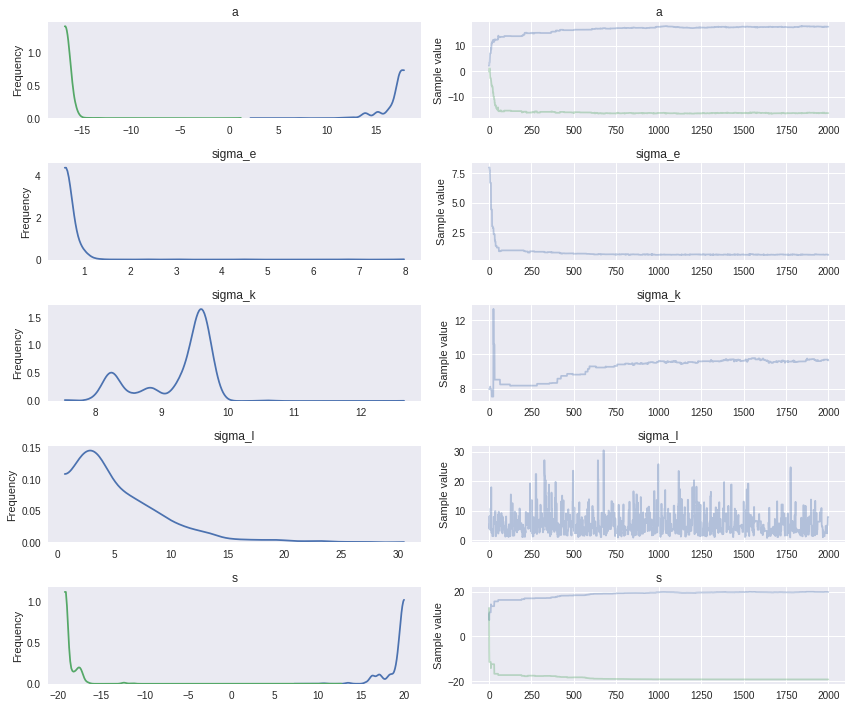

In [123]:
traceplot(trace)

In [97]:
from pymc3 import summary
print(summary(trace))


a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.297           0.688            0.066            [-1.657, 1.139]
  0.667            0.718            0.069            [-0.426, 2.126]
  0.507            0.673            0.065            [-0.590, 2.251]
  -0.103           0.883            0.087            [-1.966, 1.440]
  -0.443           0.681            0.066            [-1.987, 0.761]
  -0.016           0.987            0.097            [-2.204, 1.897]
  -0.387           0.742            0.072            [-1.939, 0.718]
  -0.195           0.890            0.087            [-1.781, 1.762]
  0.395            0.692            0.067            [-0.892, 1.872]
  0.048            1.019            0.100            [-2.004, 1.698]
  -0.579           0.703            0.068            [-1.820, 0.955]
  0.022            0.675            0.065            [-1.238, 1.254]
  0.636            0.689

In [32]:
print(trace.varnames)

['sigma_e_log_', 'sigma_k_log_', 'sigma_l_log_', 's_interval_', 'a', 'sigma_e', 'sigma_k', 'sigma_l', 's']


In [ ]:
a_post = np.percentile(trace['a'], 50, axis=0)
s_post = np.percentile(trace['s_interval_'], 50, axis=0)
sigma_k_post = np.percentile(trace['sigma_k'], 50, axis=0)

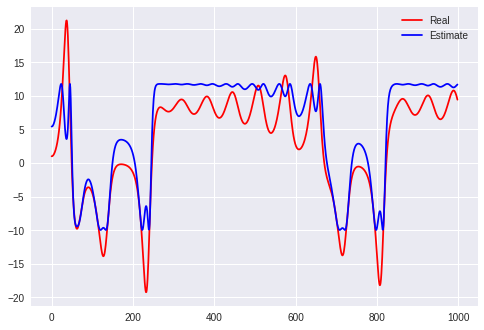

In [124]:
import matplotlib.lines as mlines

y_estimate = logp_mean(x, s_post, a_post, sigma_k_post)
plt.plot(x, 'r')
plt.plot(y_estimate, 'b')

blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Estimate')
red_line = mlines.Line2D([], [], color='red', markersize=15, label='Real')
plt.legend(handles=[red_line, blue_line])

In [61]:
from peakutils.plot import plot as pplot
import seaborn as sns

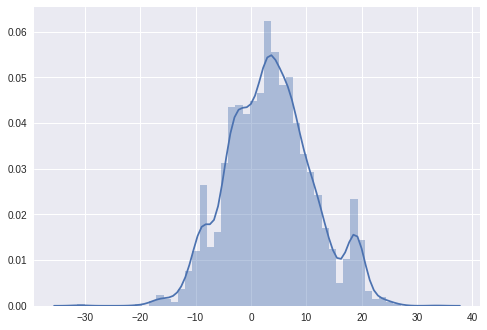

In [62]:
sns.distplot(trace['a'][:, 1])

(array([   2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    1.,    0.,    5.,    6.,   11.,
           5.,    7.,    4.,   12.,   22.,   39.,   37.,  104.,  109.,
          54.,   58.,   76.,  116.,  166.,  202.,  200.,  183.,  174.,
         197.,  179.,  217.,  279.,  243.,  242.,  196.,  228.,  214.,
         191.,  155.,  130.,  127.,  126.,   94.,   73.,   68.,   50.,
          24.,   27.,   48.,   89.,  114.,   43.,   15.,    9.,    6.,
           9.,    7.,    2.,    2.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.]),
 array([-31.325113  , -30.46047325, -29.5958335 , -28.73119374,
        -27.86655399, -27.00191424, -26.13727449, -25.27263474,
        -24.40799499, -23.54335523, -22.67871548, -21.81407573,
        -20.94943598, -20.08479623, -19.22015648, -18.35551673,
        -17.49087697, -16.62623722, -15.76159747, -14.89695772,
        -14.03231797, -13.16767822, -12.30303846, -11.43839871,
        -10.57375

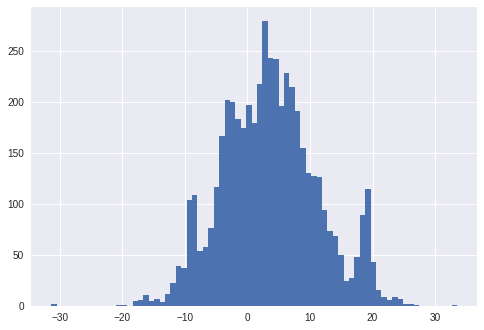

In [72]:
plt.hist(trace['a'][:,1], bins=75)

In [83]:
array = np.histogram(trace['a'][:, 1], bins=75)[1]
a_post_peaks = [array[i] for i in (26, 32, 39, 58)]

In [ ]:
# WHITEBOARD CELL, funciones que usé o podría usar eventualmente

def gram(x1, x2):
    return x1[:, 1].dimshuffle([0, 'x', 1]) - x2[:, 1].dimshuffle(['x', 0, 1])

#def logp_mean(x, sv, alpha, sigma_k):
    """ 
    N >= n
    x: shape(N,1)
    sv: shape(n, 1)
    alpha: shape(n, 1)
    return: shape(N, 1)
    """
#    return tt.dot(alpha, kern_mat(x, sv, sigma_k).T)

#def kern_mat(x, sv, sigma_k):
#    return tt.exp(-1/(2*sigma_k**2)*np.subtract.outer(x, sv)**2)
    # return tt.exp(-1/(2*sigma_k**2)*gram(x, sv)**2)
    
#0.5*T.log(2*np.pi*l**2) - 1/(2*l**2)*T.sum(T.exp(-1/(2*sigma_k**2)*np.subtract.outer(value, value))**2))


In [ ]:
# map_params = find_MAP(model=adaptive_model)
# print(map_params)
# print(map_params.keys())
# y_estimate = logp_mean(x, map_params['s_interval_'], map_params['a'], np.exp(map_params['sigma_k_log_']))
# plt.plot(x, 'r')
# plt.plot(y_estimate, 'b')